The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


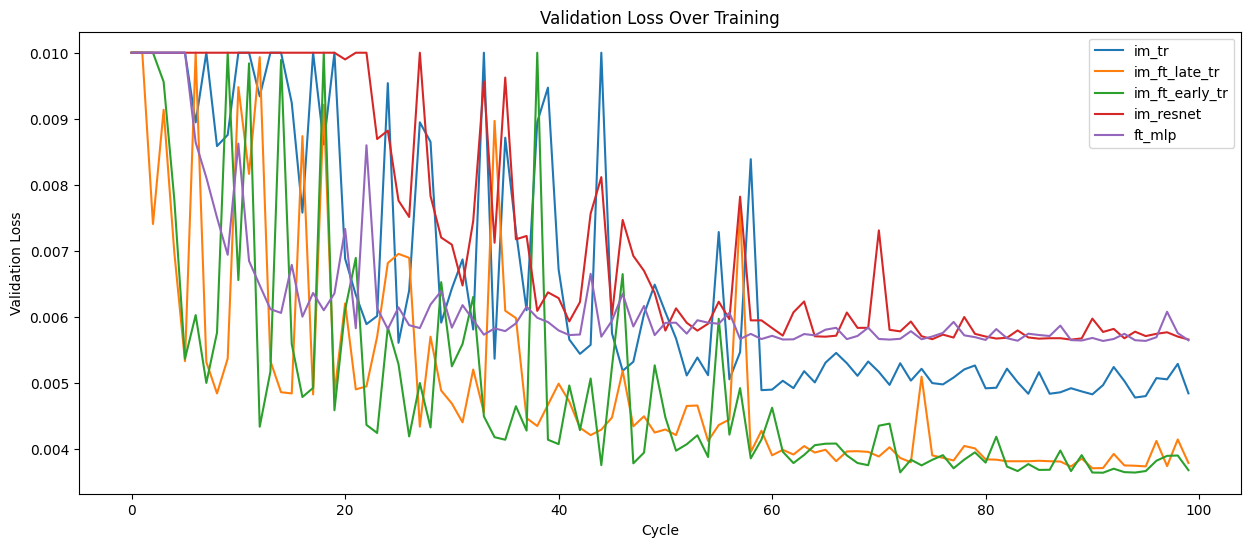

In [2]:
import torch
import matplotlib.pyplot as plt
from trainSettingsImagesFeatures import *
from helpersPlot import *
import pandas as pd
import seaborn as sns


%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# Load training results
results = torch.load("training_results_ImFt.pth",map_location=torch.device('cpu'))

# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]
plt.figure(figsize=(15, 6))  # <-- Add this line to control figure size


# Example: Plot validation loss curves
for model_name, losses in validation_losses.items():
    plt.plot(np.clip(losses["val_avg"],0,0.01), label=model_name)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()


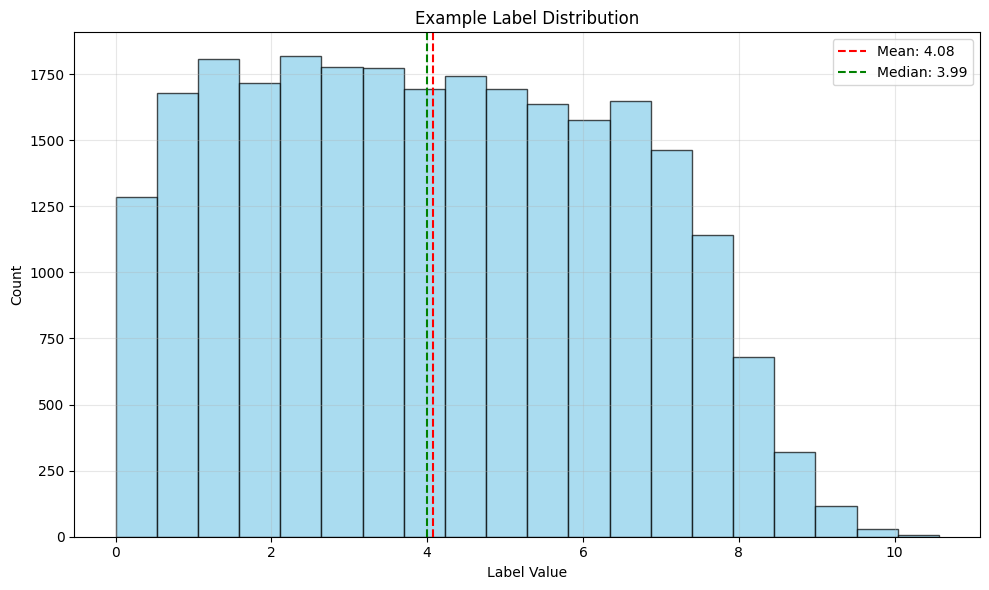

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):
    """
    Plot a histogram from a numpy array of labels.
    
    Parameters:
    -----------
    labels_array : numpy.ndarray
        The array of values to plot as histogram
    bins : int or sequence, default=10
        Number of bins or bin edges
    title : str, default="Distribution of Labels"
        Title of the plot
    xlabel : str, default="Value"
        Label for x-axis
    ylabel : str, default="Frequency"
        Label for y-axis
    color : str, default='skyblue'
        Color of the histogram bars
    edgecolor : str, default='black'
        Color of the histogram bar edges
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    show_grid : bool, default=True
        Whether to show grid lines
    show_mean : bool, default=True
        Whether to show the mean line
    show_median : bool, default=True
        Whether to show the median line
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
        For further customization if needed
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Example data
    
    # Plot histogram
    fig, ax = plot_labels_histogram(
        all_labels, 
        bins=20,
        title="Example Label Distribution",
        xlabel="Label Value",
        ylabel="Count"
    )
    
    plt.show()

In [3]:

models, optimizers, schedulers = getTrainingModels()

# Load model weights
for name, model in models.items():
    if name in model_weights:
        model.load_state_dict(model_weights[name])
        model.eval()  # Set to evaluation mode
        print(f"Loaded weights for {name}")
    else:
        print(f"Warning: No saved weights found for {name}")

Loaded weights for im_tr
Loaded weights for im_ft_late_tr
Loaded weights for im_ft_early_tr
Loaded weights for im_resnet
Loaded weights for ft_mlp


In [4]:
# Load validation dataset (fixed, does not change across cycles)
val_videos = load_validation_data(length=nFrames)  # Returns (vid1, vid3, vid5, vid7, vid_in_order)

def load_trajs(length=nFrames):
    trajs1 = np.load("./valTrajs"+str(length)+"/val1.npy") /traj_div_factor
    trajs3 = np.load("./valTrajs"+str(length)+"/val3.npy") /traj_div_factor
    trajs5 = np.load("./valTrajs"+str(length)+"/val5.npy") /traj_div_factor
    trajs7 = np.load("./valTrajs"+str(length)+"/val7.npy") /traj_div_factor
    trajs_in_order = np.load("./valTrajsInOrder.npy") /traj_div_factor

    return trajs1,trajs3,trajs5,trajs7,trajs_in_order

val_trajs = load_trajs(nFrames)

val_vid_in_order = val_videos[4][0]
val_feat_in_order = val_videos[4][1]

print(val_vid_in_order.shape, val_feat_in_order.shape)

print(val_d_in_order.shape)
val_labels = torch.tensor([1, 3, 5, 7], dtype=torch.float32)  # Corresponding labels

torch.Size([70, 10, 30, 9, 9]) torch.Size([70, 10, 25])
(70,)


In [5]:
def plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels):
    """
    Plots a 2x2 grid of violin plots for the predictions of all models for specific validation labels.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7]) for example).
    - chosen_labels (list): List of validation labels to visualize (e.g., [7.0, 3.0, 1.0]).
    """
    
    # Check that all chosen labels are in the validation labels
    for chosen_label in chosen_labels:
        if chosen_label not in val_labels.tolist():
            print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
            return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 14))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten axes for easy iteration

    # Loop over the chosen labels and corresponding axes
    for idx, chosen_label in enumerate(chosen_labels):
        label_idx = val_labels.tolist().index(chosen_label)
        chosen_video = val_videos[label_idx]  # Get corresponding video

        predictions = {}

        # Compute predictions for each model
        for name, model in models.items():
            model.eval()
            with torch.no_grad():
                preds = make_prediction_pair(model, name, chosen_video)
                preds = preds.squeeze().numpy()  # Get all predictions for this video
                # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                predictions[name] = preds * D_max_normalization  

        # Prepare data for Seaborn
        data = []
        for model_name, preds in predictions.items():
            for pred in preds:
                data.append({"Model": model_name, "Prediction": pred})

        # Convert to DataFrame for easy plotting
        df = pd.DataFrame(data)

        # Plot violin plot in the corresponding subplot
        sns.violinplot(x="Model", y="Prediction", data=df, inner="box", hue="Model", palette="coolwarm", ax=axes[idx])

        # Add reference line for true label
        axes[idx].axhline(y=chosen_label, color='r', linestyle='--', label=f"True Value: {chosen_label}")

        axes[idx].set_xlabel("Model")
        axes[idx].set_ylabel("Predicted Value")
        axes[idx].set_title(f"Model Predictions for Label {chosen_label}")
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend()

    plt.tight_layout()  # Adjust subplots to fit nicely
    plt.show()

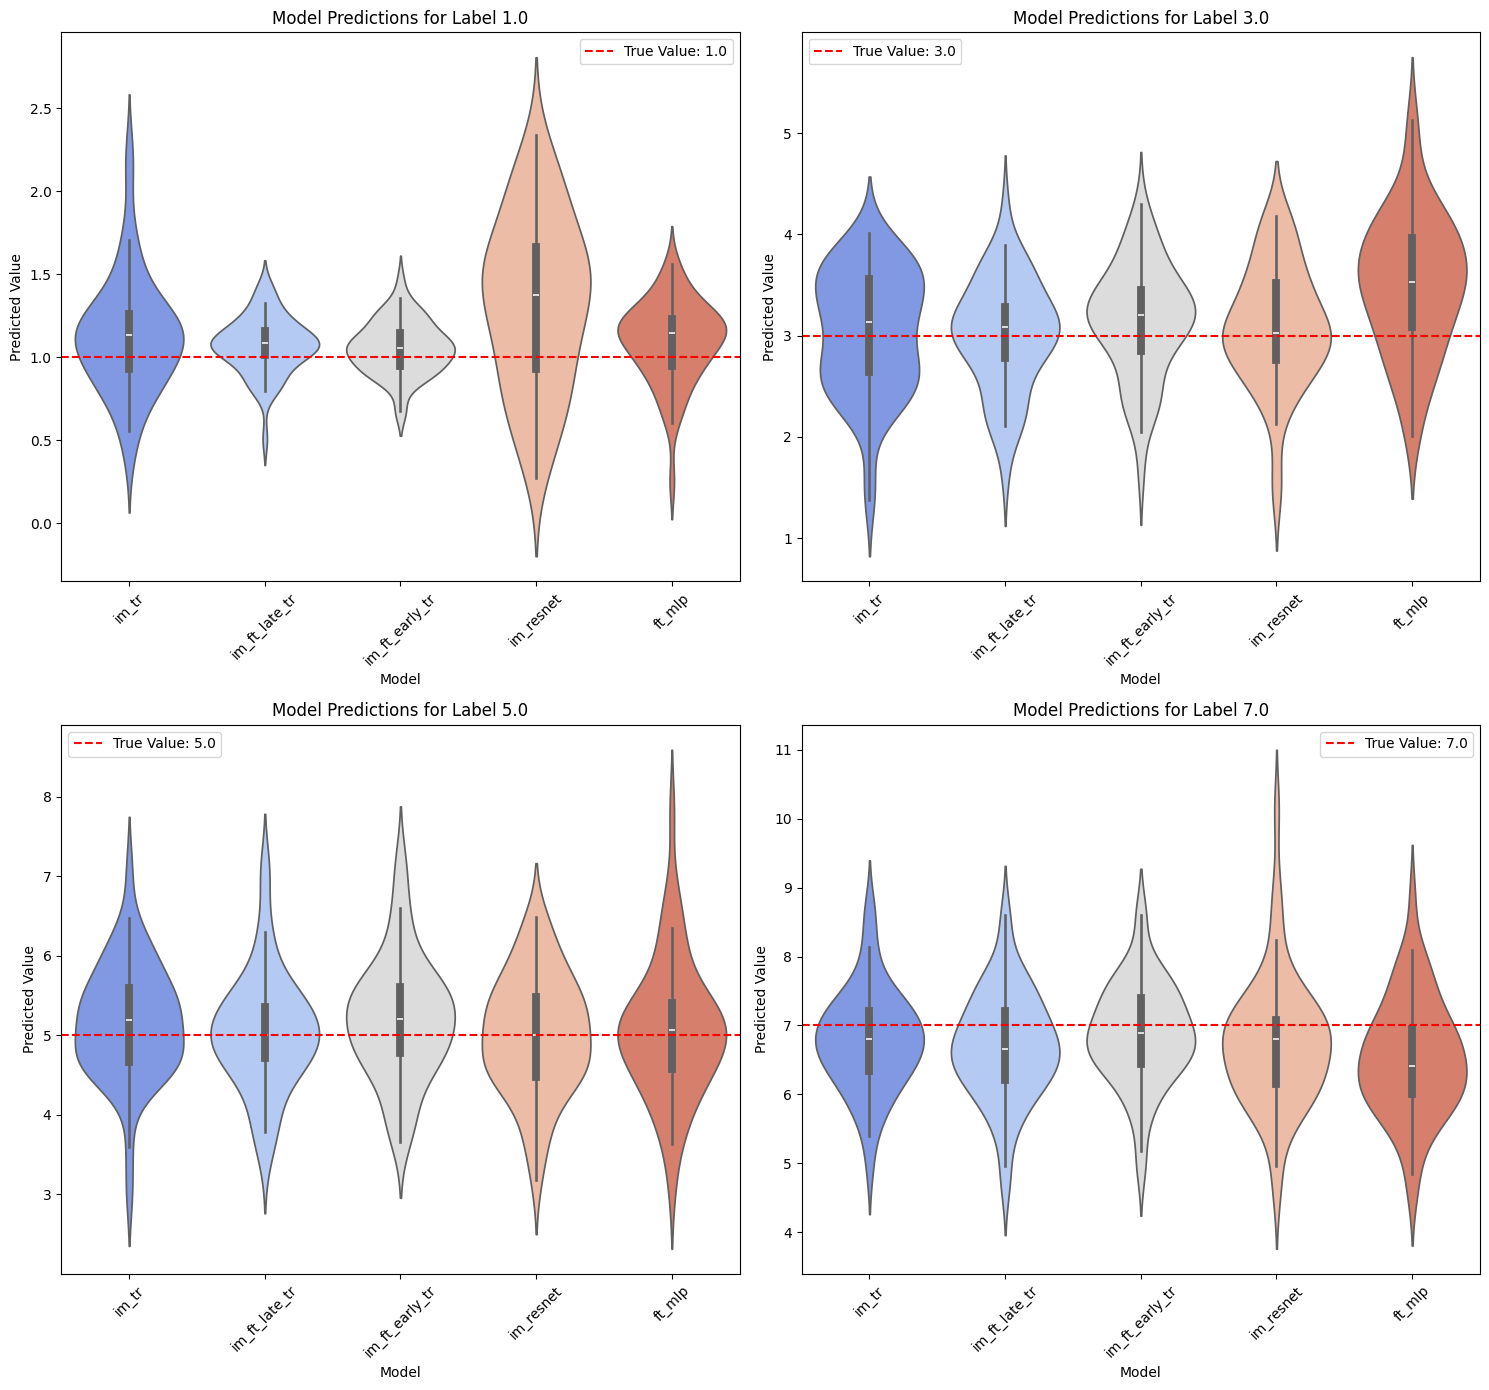

In [6]:
# Example usage
chosen_labels = [1.0, 3.0, 5.0, 7.0]
plot_model_predictions_violin(models, val_videos, val_labels, chosen_labels)

c:\Users\Silly Emilien\Documents\EPFL\Ma2\Project\SPT_VisionModel\helpersFeatures.py:171: OptimizeWarning: Covariance of the parameters could not be estimated
  params, pcov = curve_fit(


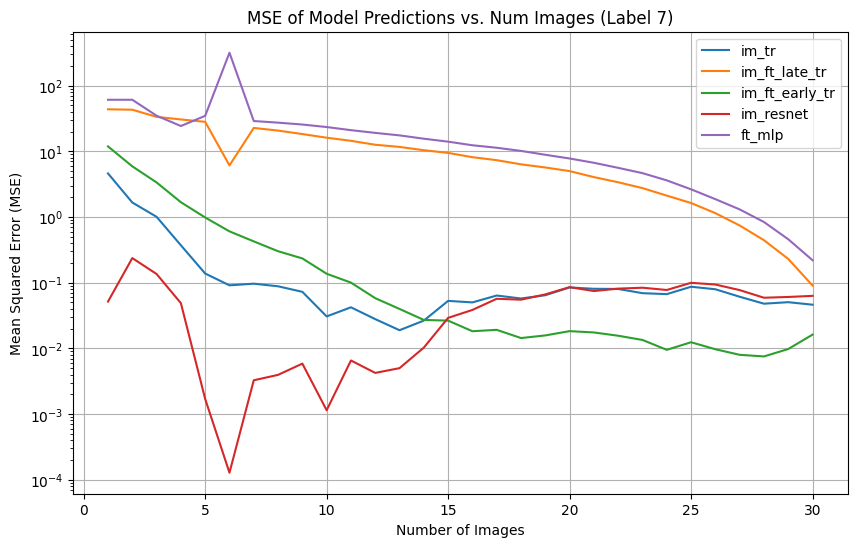

In [9]:
def plot_mse_vs_num_images(models, val_videos, val_labels, chosen_label, selected_models, val_trajs):
    """
    Plots the Mean Squared Error (MSE) of model predictions as a function of num_images.
    
    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """
    
    
    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return
    
    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx][0]  # Get corresponding video
    chosen_trajs = val_trajs[label_idx]  # Get corresponding video


    num_images_range = range(1, chosen_video.shape[1] + 1)  # Range of num_images
    mse_results = {name: [] for name in selected_models}  # Store MSE results
    
    for num_images in num_images_range:
        input_video = chosen_video[:,:num_images]  # Select subset of images
        input_trajs = chosen_trajs[:,:num_images*nPosPerFrame]


        input_features = compute_features_for_multiple_trajectories(input_trajs, dt=dt, nPosPerFrame=nPosPerFrame)
        input_features = torch.Tensor(input_features)

        for name, model in models.items():
            if(name in selected_models):
                model.eval()
                with torch.no_grad():
                    
                    pred = make_prediction(model,name,input_video.contiguous(),input_features).mean().item() 
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    pred = pred * D_max_normalization 
                    mse = (pred - chosen_label) ** 2  # Compute MSE
                    mse_results[name].append(mse)
    
    # Plot MSE as a function of num_images
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name)
    
    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"MSE of Model Predictions vs. Num Images (Label {chosen_label})")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

selected_models = models.keys()
plot_mse_vs_num_images(models, val_videos, val_labels, 7, selected_models, val_trajs)

(70, 10, 300, 2)


c:\Users\Silly Emilien\Documents\EPFL\Ma2\Project\SPT_VisionModel\helpersFeatures.py:171: OptimizeWarning: Covariance of the parameters could not be estimated
  params, pcov = curve_fit(


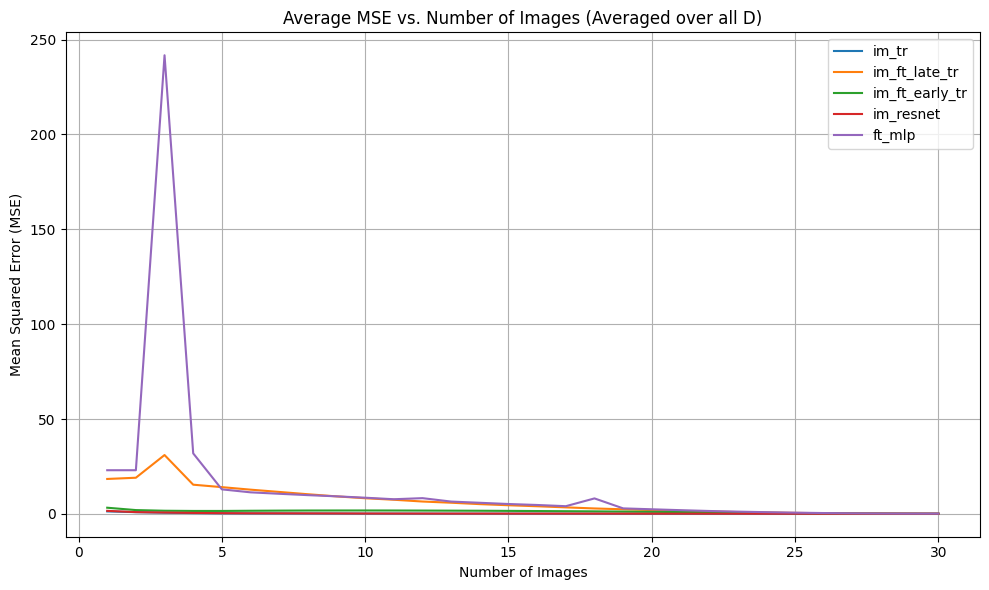

In [11]:
def plot_mse_vs_num_images_all_D(models, val_vid_in_order, val_d_in_order, selected_models, val_trajs_in_order):
    """
    Plots the average MSE of model predictions across all D values as a function of the number of images.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (Tensor or ndarray): shape (70, 10, 30, 7, 7)
    - val_d_in_order (list or array): true D values, length 70.
    - selected_models (list): names of models to include in the plot.
    """

    # get video from pair images, features 
    val_vid_in_order = val_vid_in_order

    num_frames = val_vid_in_order.shape[2]
    num_images_range = range(1, num_frames + 1)  # From 1 to 30
    mse_results = {name: [] for name in selected_models}

    for num_images in num_images_range:
        for name in selected_models:
            model = models[name]
            model.eval()
            total_mse = 0.0
            with torch.no_grad():
                for i, true_d in enumerate(val_d_in_order):
                    videos = val_vid_in_order[i, :, :num_images]  # shape (10, num_images, 7, 7)

                    input_trajs = val_trajs_in_order[i,:,:num_images*nPosPerFrame]

                    
                    input_features = compute_features_for_multiple_trajectories(input_trajs, dt=dt, nPosPerFrame=nPosPerFrame)
                    input_features = torch.Tensor(input_features)

                    preds = make_prediction(model, name, videos, input_features)  # assume shape (10, N)
                    mean_preds = preds.mean(dim=1)  # mean over frames
                    # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                    mean_preds = mean_preds * D_max_normalization
                    mean_over_10 = mean_preds.mean().item()  # mean over 10 samples
                    total_mse += (mean_over_10 - true_d) ** 2
            avg_mse = total_mse / len(val_d_in_order)
            mse_results[name].append(avg_mse)

    # Plotting
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name)

    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Average MSE vs. Number of Images (Averaged over all D)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mse_vs_num_images_all_D(models, val_vid_in_order, val_d_in_order, selected_models, val_trajs[4])


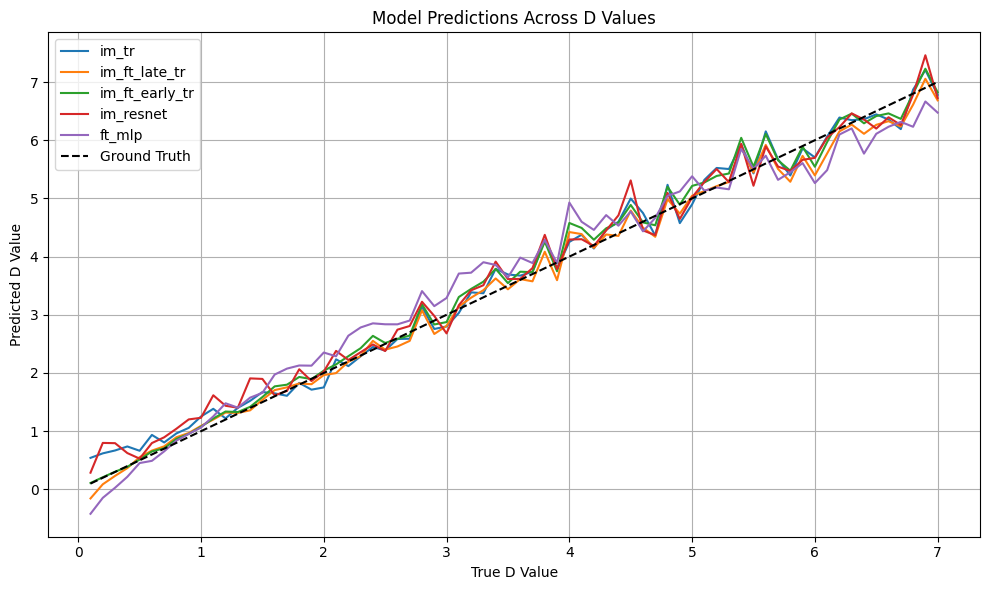

In [15]:

def plot_model_predictions_vs_D_in_order(models, val_vid_in_order, val_feat_in_order, val_d_in_order, selected_models):
    """
    Plots line graphs of model predictions across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """



    model_preds = {name: [] for name in selected_models}

    for i in range(len(val_d_in_order)):
        vids = val_vid_in_order[i]  # shape (10, 30, 7, 7)
        feats = val_feat_in_order[i]  # shape (10, 30, 7, 7)

        for name in selected_models:
            model = models[name]
            model.eval()
            with torch.no_grad():

                preds = make_prediction(model, name, vids, feats)

                # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
                preds = preds * D_max_normalization
                mean_of_means = preds.mean().item()  # mean over sequences
                model_preds[name].append(mean_of_means)

    # Plot
    plt.figure(figsize=(10, 6))
    for name, preds in model_preds.items():
        plt.plot(val_d_in_order, preds, label=name)

    plt.plot(val_d_in_order, val_d_in_order, 'k--', label='Ground Truth')  # y = x reference
    plt.xlabel("True D Value")
    plt.ylabel("Predicted D Value")
    plt.title("Model Predictions Across D Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_predictions_vs_D_in_order(models, val_vid_in_order, val_feat_in_order, val_d_in_order, selected_models)

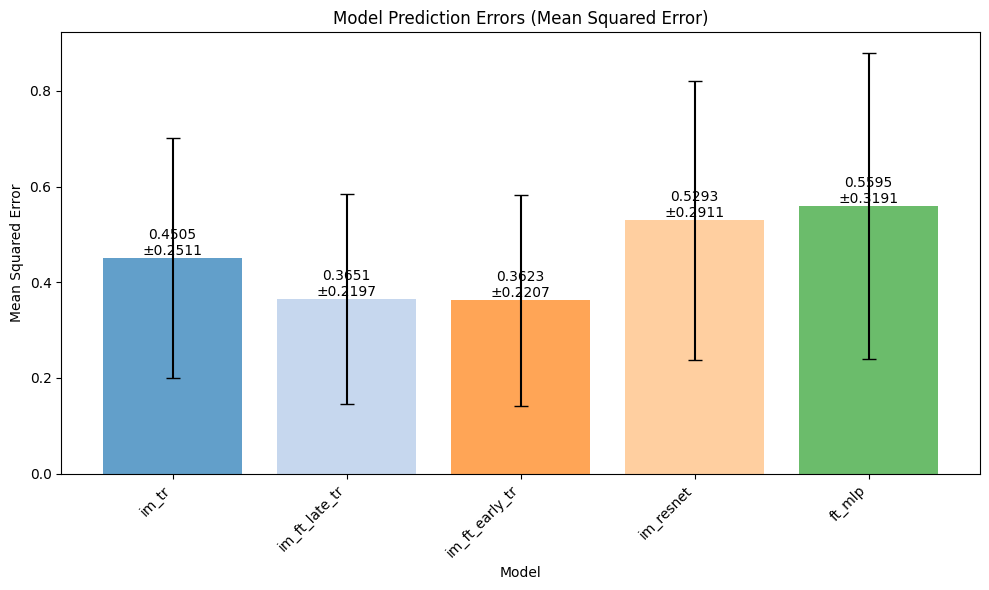

In [23]:
def plot_error_std(selected_models, mse_dict, std_dict):
    """
    Plot bar graph of Mean Squared Error with error bars representing standard deviation.

    Args:
    - selected_models (list): List of model names
    - mse_dict (dict): Dictionary of Mean Squared Errors for each model
    - std_dict (dict): Dictionary of standard deviations for each model
    """
    plt.figure(figsize=(10, 6))
    tab20_colors = plt.get_cmap('tab20').colors

    # Prepare data for plotting
    model_names = list(selected_models)
    mean_errors = [mse_dict[name] for name in model_names]
    std_errors = [std_dict[name] for name in model_names]
    
    # Create bar plot with error bars
    plt.bar(model_names, mean_errors, yerr=std_errors, 
            capsize=5, alpha=0.7, 
            color=tab20_colors)
    
    plt.title('Model Prediction Errors (Mean Squared Error)')
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add error values as text on the bars
    for i, (mean, std) in enumerate(zip(mean_errors, std_errors)):
        plt.text(i, mean, f'{mean:.4f}\n±{std:.4f}', 
                 ha='center', va='bottom')
    
    plt.show()

def plot_erro_all_d(models, val_vid_in_order, val_feat_in_order, val_d_in_order, selected_models):
    """
    Plots line graphs of model predictions and bar graph of errors across increasing D values.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_vid_in_order (numpy array or torch.Tensor): Array of shape (70, 10, 30, 7, 7).
    - val_d_in_order (list or array): Corresponding true D values (length 70).
    """


    if isinstance(val_d_in_order, np.ndarray):
        val_d_in_order = torch.tensor(val_d_in_order, dtype=torch.float32)


    # Reshape video tensor to (700, 30, 9, 9)
    val_vid_reshaped = val_vid_in_order.view(-1, 30, 9, 9).to(device)
    val_feat_reshaped = val_feat_in_order.view(-1, 25)
    # Explicitly repeat val_d_in_order 10 times to create a (700,) array
    true_d_repeated = torch.repeat_interleave(val_d_in_order, repeats=10).unsqueeze(1)

    # Dictionaries to store predictions, MSE, and standard deviation
    model_preds = {name: [] for name in selected_models}
    mse_dict = {}
    std_dict = {}

    for name in selected_models:
        model = models[name]
        model.eval()
        with torch.no_grad():
                
            preds = make_prediction(model, name, val_vid_reshaped, val_feat_reshaped)

            # Multiply by D_max_normalization because model was trained to predict values between 0 and 1
            preds = preds * D_max_normalization

            # Extract numpy arrays from tensors
            preds_np = preds.cpu().numpy()
            true_np = true_d_repeated.cpu().numpy()
            errors = preds_np - true_np
            # Add epsilon to denominator to avoid division by zero
            epsilon = 1e-8
            scaled_errors = errors / (true_np + epsilon)
            scaled_errors = errors
            # Step 3: Compute the scaled Mean Squared Error (MSE)
            scaled_mse = np.mean(scaled_errors**2)
            #scaled_mse = np.mean(np.abs(scaled_errors))

            # Step 4: Compute the standard deviation of the scaled squared errors
            scaled_std = np.std(scaled_errors**2)/3
            #scaled_std = np.std(np.abs(scaled_errors))

            # Store MSE and standard deviation
            mse_dict[name] = scaled_mse
            std_dict[name] = scaled_std

            # Potentially create prediction plot
            model_preds[name] = preds.mean().item()

    plot_error_std(selected_models, mse_dict, std_dict)


plot_erro_all_d(models, val_vid_in_order, val_feat_in_order, val_d_in_order, models.keys())
